[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/NktBkzn/HSE_DL_2021/blob/master/12_week/RNNs.ipynb)

- Ноутбук заимствован с курса [dlcourse.ai](https://dlcourse.ai)
- Решение ноутбука взято [отсюда](https://github.com/omega1996/dlcourse/blob/master/assignments/assignment6/RNNs.ipynb)

# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [ ]:
!pip install gensim==4.1.2
!pip install nltk==3.6.3
!pip install scikit-learn==1.0.1

In [1]:
import nltk
nltk.__version__

'3.6.3'

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [4]:
len(data), len(data[0]), len(data[1])

# list(list(tuple))

# (word, tag)

(57340, 25, 43)

In [5]:
data[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Пример размеченного предложения:

In [6]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [7]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [8]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}  # ind + 1 to leave 0 idx blank for <pad>
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'PRON', 'ADJ', 'VERB', 'X', 'CONJ', 'DET', 'ADP', 'ADV', '.', 'PRT', 'NUM', 'NOUN'}


In [19]:
type(words), type(tags)

(set, set)

In [10]:
tag2ind

{'PRON': 1,
 'ADJ': 2,
 'VERB': 3,
 'X': 4,
 'CONJ': 5,
 'DET': 6,
 'ADP': 7,
 'ADV': 8,
 '.': 9,
 'PRT': 10,
 'NUM': 11,
 'NOUN': 12,
 '<pad>': 0}

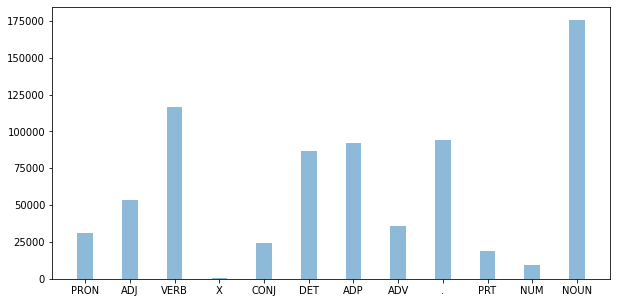

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

На вход UnigramTagger принимает данные в таком формате:\
*train (list(list(tuple(str, str)))) – The corpus of training data, a list of tagged sentences*

In [21]:
test_data[:2]

[[('Open', 'ADJ'), ('market', 'NOUN'), ('policy', 'NOUN')],
 [('And', 'CONJ'),
  ('you', 'PRON'),
  ('think', 'VERB'),
  ('you', 'PRON'),
  ('have', 'VERB'),
  ('language', 'NOUN'),
  ('problems', 'NOUN'),
  ('.', '.')]]

In [22]:
import nltk

default_tagger = nltk.DefaultTagger('NN')  # tags every word witn a noun

# The UnigramTagger finds the most likely tag for each word in a training corpus, 
# and then uses that information to assign tags to new tokens.
unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Хорошая [заметка](https://stackoverflow.com/questions/46713629/evaluating-pos-tagger-in-nltk) на SO про синтаксис Taggers из nltk

Выжимка:
```python
tagged_sentences = brown.tagged_sents(categories="news", tagset="universal")

# let's keep 20% of the data for testing, and 80 for training
i = int(len(tagged_sentences)*0.2)
train_sentences = tagged_sentences[i:]
test_sentences = tagged_sentences[:i]

# train
unigram_tagger = UnigramTagger(train_sentences)
# get ACCURACY; default evaluation metric for nltk taggers is accuracy
accuracy = unigram_tagger.evaluate(test_sentences)

tagged_test_sentences = unigram_tagger.tag_sents([[token for token,tag in sent] for sent in test_sentences])  # words(tokens) only
pred = [str(tag) for sentence in tagged_test_sentences for token,tag in sentence]  # predicted tags
gold = [str(tag) for sentence in test_sentences for token,tag in sentence]  # true tags

from sklearn import metrics
print(metrics.classification_report(gold, pred))
```

Добавим вероятности переходов:

In [23]:
# A tagger that chooses a token’s tag based its word string and on the preceding 
# words’ tag. In particular, a tuple consisting of the previous tag and 
# the word is looked up in a table, and the corresponding tag is returned.
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [24]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


In [25]:
trigram_tagger = nltk.TrigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 93.28%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [26]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [29]:
X_train[0]

[3840,
 39349,
 19731,
 5740,
 44855,
 13384,
 5690,
 20281,
 37024,
 37238,
 33012,
 34562,
 33802,
 1765,
 25694,
 24701,
 11223,
 13281,
 13281]

In [33]:
y_train[0]

[9, 6, 3, 1, 3, 7, 12, 12, 7, 12, 5, 12, 7, 6, 2, 12, 9, 9, 9]

In [34]:
len(X_train), len(train_data)

# len(data[0]), len(data[1])

(36554, 36554)

In [36]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)
    # print('n_samples', n_samples)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        # Создаем матрицы, заполненные нулями, которые ниже будут заполнены значениями
        batch_indices = indices[start:end]
        # print('batch_indices', batch_indices)
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        # print('max_sent_len', max_sent_len)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        # заполнение созданных матриц значениями (с учетом того, что все предложения разной длины)
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [37]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

In [38]:
print(X_batch[:2])

print(y_batch[:2])

[[42067. 42054. 22613.  1765.]
 [10205. 28911.  7910.  2248.]]
[[ 4. 12.  3.  6.]
 [12. 12.  7. 12.]]


**Задание** Реализуйте `LSTMTagger`:

* [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
    - Input: (∗)
    - Output: (∗, H)
* [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
    - Input: (N, L, H_in) или (L, N, H_in) в зависимости от значения `batch_first`
    - Output: (N, L, D * H_out), (h_n, c_n)\
    D = 2 if bidirectional=True otherwise 1

$L\times bs \xrightarrow{\text{nn.Embedding}} L \times bs \times H_{in} \xrightarrow{\text{nn.LSTM}} L \times bs \times H^*_{out}\xrightarrow{\text{nn.Linear}} L \times bs \times \text{tagset_size}$ 

\*$H_{out}$ = lstm_hidden_dim

- L - sequence length
- bs - batch size
- $H_{in}$ - number of input features representing an object
- $H_{out}$ - number of output features representing an object

In [47]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, word_emb_dim)
        self._lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        # print('emb shape:', emb.shape)
        output, _ = self._lstm(emb)
        out = self._out_layer(output)
        return out

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [ ]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)
preds = torch.argmax(logits, dim=-1)

# accuracy
mask = (y_batch != 0).float() # помним, что тэг 0 соотвествует слову <pad>, не учитываем <pad> в рассчете точности
correct_count = ((preds == y_batch).float() * mask).sum().item()
total_count = mask.sum().item()

#print(f'Accuracy: {correct_count / total_count:.4f}')

In [46]:
print(X_batch.shape, logits.shape, preds.shape)
# 32x4 ->(embed) 32x4x100 ->(lstm) 32x4x128 ->(linear) 32x4x13
preds[:2]

torch.Size([32, 4]) torch.Size([32, 4, 13]) torch.Size([32, 4])


tensor([[5, 9, 0, 5],
        [6, 9, 5, 1]])

In [42]:
print(y_batch.shape)
y_batch

torch.Size([32, 4])


tensor([[ 4, 12,  3,  6],
        [12, 12,  7, 12],
        [ 7,  9, 12,  3],
        [ 6,  1,  8,  2],
        [12,  3,  7,  9],
        [ 9, 12, 12,  6],
        [ 6,  4,  9, 12],
        [12,  4, 12,  2],
        [ 7,  7,  3,  5],
        [12,  6,  6,  3],
        [ 9,  3, 12,  9],
        [ 1, 12,  7,  5],
        [ 3,  9,  6, 10],
        [ 9,  3,  2,  3],
        [ 0, 11, 12,  8],
        [ 0,  8,  9,  3],
        [ 0,  2,  6, 10],
        [ 0,  7, 12,  3],
        [ 0,  6,  7,  2],
        [ 0, 12,  6, 12],
        [ 0,  7,  6,  7],
        [ 0, 12, 12,  1],
        [ 0,  9,  3,  9],
        [ 0,  0,  3,  0],
        [ 0,  0,  3,  0],
        [ 0,  0,  3,  0],
        [ 0,  0,  1,  0],
        [ 0,  0,  8,  0],
        [ 0,  0,  6,  0],
        [ 0,  0,  2,  0],
        [ 0,  0, 12,  0],
        [ 0,  0,  9,  0]])

[nn.CrossEnropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=ignore_index)

$LogLoss = -\sum_{i=1}^{C} t_i log(p_i)$

$\ell(x, y)=L=\left\{l_{1}, \ldots, l_{N}\right\}^{\top}, \quad l_{n}=-w_{y_{n}} \log \dfrac{\exp \left(x_{n, y_{n}}\right)}{\sum_{c=1}^{C} \exp \left(x_{n, c}\right)} \cdot 1\left\{y_{n} \neq\right. \text { ignore_index }\}$

In [49]:
criterion = nn.CrossEntropyLoss(ignore_index=0) # при расчете Loss не учитывается 0-tag
logits = model(X_batch)
loss = 0
for ind, row in enumerate(logits):
    loss += criterion(row, y_batch[ind])  # Input: (N, C) & (N) where C - classes #
print(loss)

tensor(81.5645, grad_fn=<AddBackward0>)


**Задание** Вставьте эти вычисление в функцию:

In [50]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = 0
                for ind, row in enumerate(logits):
                    loss += criterion(row, y_batch[ind])

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(logits, dim=-1)
                mask = (y_batch != 0).float()
                
                cur_correct_count, cur_sum_count = ((preds == y_batch).float() * mask).sum().item(), mask.sum().item()

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [51]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=5,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 5] Train: Loss = 49.84052, Accuracy = 73.79%: 100%|██████████| 572/572 [00:08<00:00, 65.33it/s]
[1 / 5]   Val: Loss = 45.82435, Accuracy = 83.66%: 100%|██████████| 13/13 [00:00<00:00, 62.12it/s]
[2 / 5] Train: Loss = 23.49648, Accuracy = 87.07%: 100%|██████████| 572/572 [00:07<00:00, 74.03it/s]
[2 / 5]   Val: Loss = 33.13837, Accuracy = 88.25%: 100%|██████████| 13/13 [00:00<00:00, 59.98it/s]
[3 / 5] Train: Loss = 16.03217, Accuracy = 91.24%: 100%|██████████| 572/572 [00:07<00:00, 74.76it/s]
[3 / 5]   Val: Loss = 24.51983, Accuracy = 90.85%: 100%|██████████| 13/13 [00:00<00:00, 62.22it/s]
[4 / 5] Train: Loss = 11.77118, Accuracy = 93.37%: 100%|██████████| 572/572 [00:07<00:00, 74.77it/s]
[4 / 5]   Val: Loss = 22.83931, Accuracy = 92.01%: 100%|██████████| 13/13 [00:00<00:00, 64.26it/s]
[5 / 5] Train: Loss = 8.84468, Accuracy = 94.71%: 100%|██████████| 572/572 [00:07<00:00, 74.86it/s]
[5 / 5]   Val: Loss = 18.57362, Accuracy = 93.10%: 100%|██████████| 13/13 [00:00<00:00, 63.04it/s]


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [52]:
def compute_accuracy(model, data, batch_size=64):
    model.eval()
    val_accuracy = 0
    correct = 0
    total = 0
    for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
        X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
        logits = model(X_batch)
        
        pred = torch.argmax(logits, dim=-1)
        mask = (y_batch != 0).float()
        
        correct += ((pred == y_batch).float() * mask).sum().item()
        
        total += mask.sum().item()        
        
    val_accuracy = float(correct)/total
        
    return val_accuracy

test_ac =  compute_accuracy(model, (X_test, y_test))
print(f'Test accuracy is {test_ac:.2%}')

Test accuracy is 93.25%


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

Вспомним, что Unidirectional LSTM выглядела так:
```python
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, word_emb_dim)
        self._lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, num_layers=lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        # print('emb shape:', emb.shape)
        output, _ = self._lstm(emb)
        out = self._out_layer(output)
        return out
```

$L\times bs \xrightarrow{\text{nn.Embedding}} L \times bs \times H_{in} \xrightarrow{\text{nn.LSTM}} L \times bs \times D\cdot H_{out}\xrightarrow{\text{nn.Linear}} L \times bs \times \text{tagset_size}$ 

In [53]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, word_emb_dim)
        self._lstm = nn.LSTM(word_emb_dim, 
                             lstm_hidden_dim, 
                             num_layers=lstm_layers_count,
                             bidirectional = True)
        self._out_layer = nn.Linear(2*lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        output, _ = self._lstm(emb)
        out = self._out_layer(output)
        return out

In [54]:
model = BidirectionalLSTMTagger(
    lstm_layers_count=2,
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index = 0).cuda()
optimizer = optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 5e-4)

fit(model, criterion, optimizer, train_data=(X_train, y_train), 
    epochs_count=6, batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 6] Train: Loss = 21.77118, Accuracy = 88.55%: 100%|██████████| 572/572 [00:10<00:00, 56.35it/s]
[1 / 6]   Val: Loss = 17.17040, Accuracy = 94.16%: 100%|██████████| 13/13 [00:00<00:00, 25.04it/s]
[2 / 6] Train: Loss = 6.44454, Accuracy = 96.43%: 100%|██████████| 572/572 [00:10<00:00, 56.98it/s]
[2 / 6]   Val: Loss = 17.29786, Accuracy = 94.89%: 100%|██████████| 13/13 [00:00<00:00, 24.15it/s]
[3 / 6] Train: Loss = 3.99467, Accuracy = 97.41%: 100%|██████████| 572/572 [00:10<00:00, 56.90it/s]
[3 / 6]   Val: Loss = 18.39407, Accuracy = 95.10%: 100%|██████████| 13/13 [00:00<00:00, 24.10it/s]
[4 / 6] Train: Loss = 3.17534, Accuracy = 97.85%: 100%|██████████| 572/572 [00:10<00:00, 55.16it/s]
[4 / 6]   Val: Loss = 19.52398, Accuracy = 95.23%: 100%|██████████| 13/13 [00:00<00:00, 23.47it/s]
[5 / 6] Train: Loss = 2.93482, Accuracy = 97.99%: 100%|██████████| 572/572 [00:10<00:00, 56.47it/s]
[5 / 6]   Val: Loss = 15.13318, Accuracy = 95.28%: 100%|██████████| 13/13 [00:00<00:00, 24.61it/s]
[6 /

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [55]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [63]:
w2v_model.vectors.shape
w2v_model.get_vector('is').shape

(100,)

Построим подматрицу для слов из нашей тренировочной выборки:

In [58]:
w2v_model

In [61]:
w2v_model.vectors.shape

(400000, 100)

In [64]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.key_to_index:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [65]:
embeddings.shape

(45441, 100)

In [66]:
embeddings_t = torch.from_numpy(embeddings)
embeddings_t.requires_grad = True
embeddings_t = embeddings_t.float().cuda()

In [67]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding.from_pretrained(embeddings_t) # важно: по дефолту freeze=True, embeddings не обучаются!
        self._lstm = nn.LSTM(embeddings_t.shape[1], 
                             lstm_hidden_dim, 
                             num_layers=lstm_layers_count, 
                             bidirectional = True)
        self._out_layer = nn.Linear(2*lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        output, _ = self._lstm(emb)
        out = self._out_layer(output)
        return out

In [68]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=35,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 35] Train: Loss = 41.93188, Accuracy = 79.92%: 100%|██████████| 572/572 [00:07<00:00, 78.14it/s]
[1 / 35]   Val: Loss = 33.87751, Accuracy = 89.72%: 100%|██████████| 13/13 [00:00<00:00, 58.82it/s]
[2 / 35] Train: Loss = 16.39590, Accuracy = 91.90%: 100%|██████████| 572/572 [00:07<00:00, 77.49it/s]
[2 / 35]   Val: Loss = 25.02798, Accuracy = 92.38%: 100%|██████████| 13/13 [00:00<00:00, 58.54it/s]
[3 / 35] Train: Loss = 12.21005, Accuracy = 93.80%: 100%|██████████| 572/572 [00:07<00:00, 76.82it/s]
[3 / 35]   Val: Loss = 18.37932, Accuracy = 93.69%: 100%|██████████| 13/13 [00:00<00:00, 58.79it/s]
[4 / 35] Train: Loss = 9.89550, Accuracy = 94.83%: 100%|██████████| 572/572 [00:07<00:00, 78.51it/s]
[4 / 35]   Val: Loss = 16.20309, Accuracy = 94.51%: 100%|██████████| 13/13 [00:00<00:00, 58.27it/s]
[5 / 35] Train: Loss = 8.45197, Accuracy = 95.49%: 100%|██████████| 572/572 [00:07<00:00, 78.59it/s]
[5 / 35]   Val: Loss = 13.65545, Accuracy = 94.94%: 100%|██████████| 13/13 [00:00<00:00, 62.

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [69]:
test_ac =  compute_accuracy(model, (X_test, y_test))
print(f'Test accuracy is {test_ac:.2%}')

Test accuracy is 96.88%


### Сравнение результатов работы разных подходов
| №      | Название        | Точность
| :---:  |:-------------:  | :------------------ | 
| 1      | Unigram Tagger  | 92.62%              | 
| 2      | Bigram Tagger   | 93.42%              | 
| 3      | Trigram Tagger  | 93.28%              | 
| 4      | LSTM            | 94.02%              | 
| 5      | BiLSTM          | 95.42%              | 
| 6      | BiLSTM Pretrained embeddings| 96.82%  |